In [1]:
from scipy.stats import binom
import matplotlib.pyplot as plt
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import statistics

In [2]:
df = pd.read_csv('attribution_data.csv')
df

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search
...,...,...,...,...,...,...
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video


In [32]:
#First Touch
temp = df[df['conversion'] == 1]
first_touch = pd.DataFrame(df.groupby('cookie').first(), index=df['cookie'])
cookie_index = list(temp['cookie'])
first_touch_inter = first_touch.loc[cookie_index]
first_touch_final = pd.DataFrame(round(first_touch_inter['channel'].value_counts(normalize= True) * 100, 2))
first_touch_final.columns = ['Weightage(%)']
first_touch_final

,Weightage(%)
Facebook,32.59
Online Video,25.20
Paid Search,18.47
Instagram,14.78
Online Display,8.95


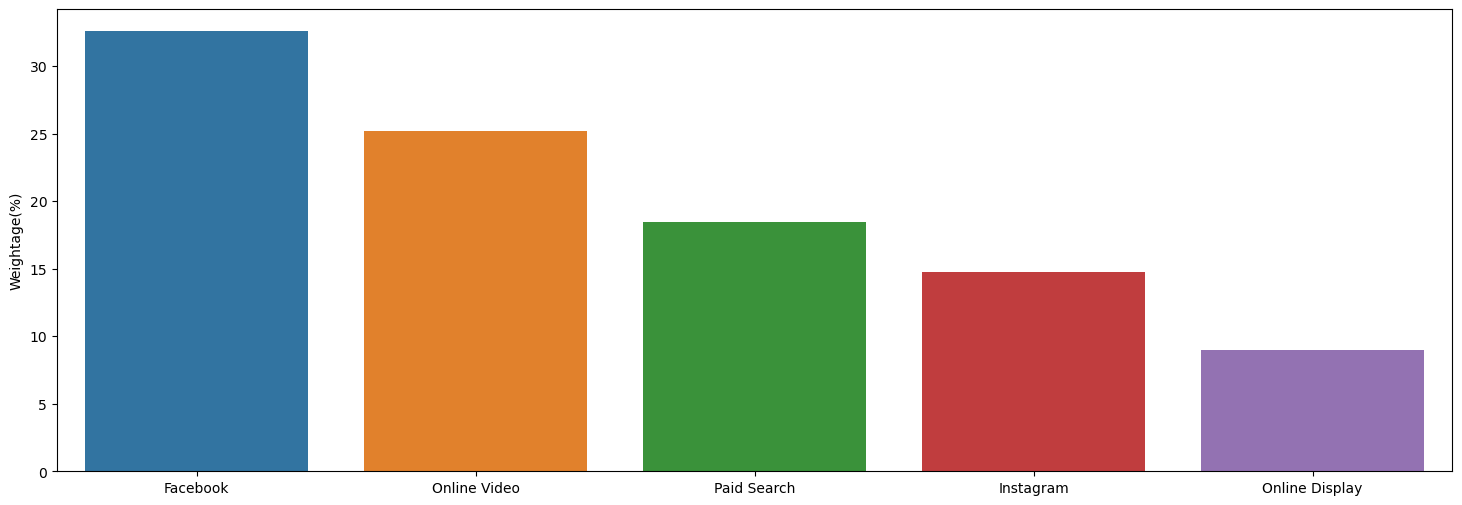

In [43]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=first_touch_final.index, data=first_touch_final)

# Display the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

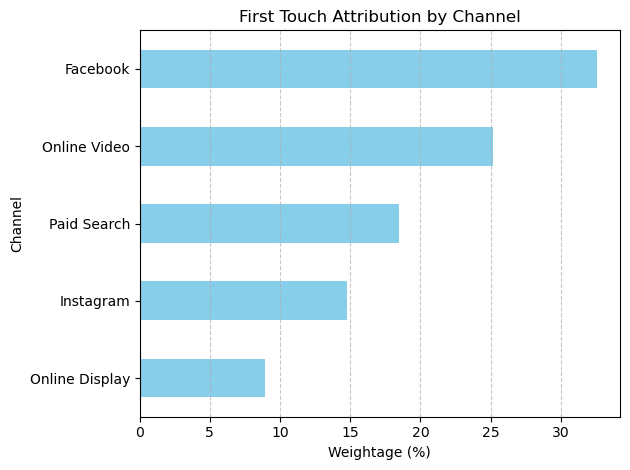

In [37]:

# Plot
plt.figure(figsize=(10, 6))
first_touch_final.sort_values(by='Weightage(%)', ascending=True).plot(kind='barh', legend=False, color='skyblue')

plt.title('First Touch Attribution by Channel')
plt.xlabel('Weightage (%)')
plt.ylabel('Channel')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [33]:
#Last Touch
last_touch_final = pd.DataFrame(round(temp['channel'].value_counts(normalize=True) * 100, 2))
last_touch_final.columns = ['Weightage(%)']
last_touch_final

,Weightage(%)
Facebook,30.05
Paid Search,25.78
Online Video,19.32
Instagram,12.72
Online Display,12.13


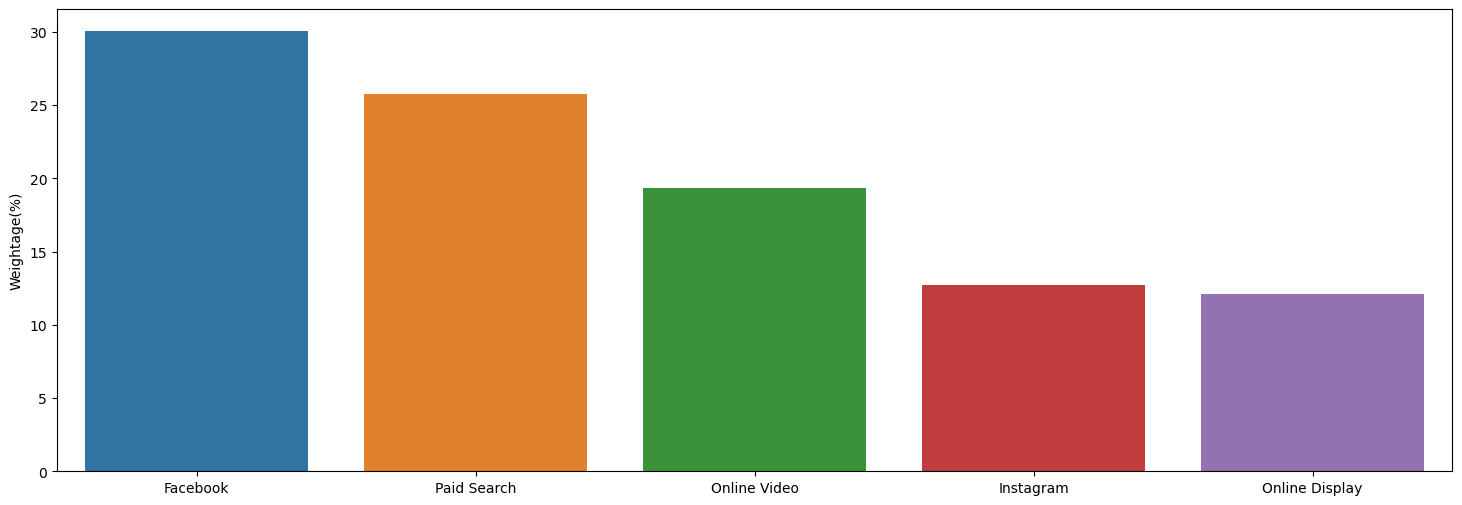

In [44]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=last_touch_final.index, data=last_touch_final)

# Display the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

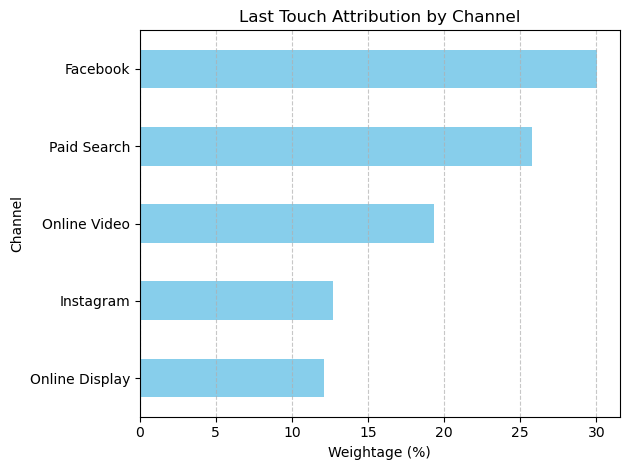

In [38]:

# Plot
plt.figure(figsize=(10, 6))
last_touch_final.sort_values(by='Weightage(%)', ascending=True).plot(kind='barh', legend=False, color='skyblue')

plt.title('Last Touch Attribution by Channel')
plt.xlabel('Weightage (%)')
plt.ylabel('Channel')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [5]:
def transition_states(list_of_paths):
    # Create a set of unique channels from all user paths
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    # Create a dictionary to store transition counts for all possible combinations
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    # Count the frequencies for all possible channel transition combinations
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states

In [6]:
from collections import defaultdict

def transition_prob(trans_dict, list_of_paths):
    # Create a set of unique channels from all user paths
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    # Initialize a defaultdict to store transition probabilities
    trans_prob = defaultdict(dict)

    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]

            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]

            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


In [7]:
def transition_matrix(list_of_paths, transition_probabilities):
    # Create an empty transition matrix as a DataFrame
    trans_matrix = pd.DataFrame()
    
    # Create a set of unique channels from all user paths
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    # Initialize the transition matrix with zeros
    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    # Fill the transition matrix with transition probabilities
    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix

In [8]:
def removal_effects(dt, conversion_rate):
    # Calculate the effect of removing each channel
    removal_effects_dict = {}
    channels = [channel for channel in dt.columns if channel not in ['Start', 'Null', 'Conversion']]
    
    for channel in channels:
        # Create a DataFrame with the channel removed
        removal_dt = dt.drop(channel, axis=1).drop(channel, axis=0)
        
        # Calculate the row sums and null percentages
        for column in removal_dt.columns:
            row_sum = np.sum(list(removal_dt.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_dt.loc[column]['Null'] = null_pct
            removal_dt.loc['Null']['Null'] = 1.0

        # Separate data for conversion and non-conversion
        removal_to_conv = removal_dt[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_dt.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        # Calculate the inverse difference
        removal_inv_diff = np.linalg.inv(np.identity(len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        
        # Calculate the dot product
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        
        # Calculate the conversion rate
        removal_cvr = pd.DataFrame(removal_dot_prod, index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        
        # Calculate the removal effect
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


In [9]:
def markov_chain_allocations(removal_effects, total_conversions):
    # Calculate the sum of removal effects
    re_sum = np.sum(list(removal_effects.values()))
    
    # Calculate allocations using removal effects and total conversions
    allocations = {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}
    
    return allocations

In [24]:
def markov_model(df, conv_col, channel_col, user_id):
    
    pd.options.mode.chained_assignment = None 
    df = df.sort_values(user_id)
    df['visit_order'] = df.groupby(user_id).cumcount() + 1

    df_paths = df.groupby(user_id)[channel_col].aggregate(lambda x: x.unique().tolist()).reset_index()
    df_last_interaction = df.drop_duplicates(user_id, keep='last')[[user_id, conv_col]]
    df_paths = pd.merge(df_paths, df_last_interaction, how='left', on=user_id)

    df_paths['start'] = [["Start"] for i in range(len(df_paths[conv_col]))]
    df_paths['buff'] = [["Conversion"] for i in range(len(df_paths[conv_col]))]
    df_paths['null'] = [["Null"] for i in range(len(df_paths[conv_col]))]


    df_paths['path'] = np.where(df_paths[conv_col] == 0, df_paths['start'] + df_paths[channel_col] + df_paths['null'], df_paths['start'] + df_paths[channel_col] + df_paths['buff'])
    df_paths = df_paths[[user_id, 'path']]

    list_of_paths = df_paths['path']
    total_conversions = np.sum(a.count('Conversion') for a in df_paths['path'].tolist())
    base_conversion_rate = total_conversions / len(list_of_paths)

    trans_states = transition_states(list_of_paths)
    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix = transition_matrix(list_of_paths, trans_prob)
    removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)    #Creating a dictionary of the removal effect
    
    print("Removal Effects by Channel:")
    for k, v in sorted(removal_effects_dict.items(), key=lambda x: x[1]):
        print(f"{k}: {v:.4f}")
    
    Least_impact_channel = min(removal_effects_dict, key=removal_effects_dict.get)
    most_impact_channel = max(removal_effects_dict, key=removal_effects_dict.get)

    print(Least_impact_channel)
    print(most_impact_channel)
    
    attributions = markov_chain_allocations(removal_effects_dict, total_conversions)    #Allocating markov chains
    res_markov=pd.DataFrame(attributions.values(),index=attributions.keys())
    res_markov.columns=['weightage']
    sum=res_markov['weightage'].sum()
    res_markov['Weightage(%)']=res_markov.apply(lambda x: round((x['weightage']/sum)*100,2),axis=1)
    res_markov.drop(['weightage'], axis=1,inplace=True)
    res_markov=res_markov.sort_index()
    return res_markov  

In [25]:
markov = markov_model(df, 'conversion', 'channel', 'cookie')
markov

/var/folders/w6/mt3qx8g56pgfshgyg2fj_vxr0000gn/T/ipykernel_16489/3032339135.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_conversions = np.sum(a.count('Conversion') for a in df_paths['path'].tolist())


Removal Effects by Channel:
Online Display: 0.1617
Online Video: 0.1936
Instagram: 0.1983
Paid Search: 0.3454
Facebook: 0.3592
Online Display
Facebook


,Weightage(%)
Facebook,28.55
Instagram,15.76
Online Display,12.85
Online Video,15.38
Paid Search,27.46


In [ ]:
# Set the figure size for the plot
plt.subplots(figsize=(18, 6))

# Create a bar plot using Seaborn
sns.barplot(y='Weightage(%)', x=markov.index, data=markov)

# Display the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

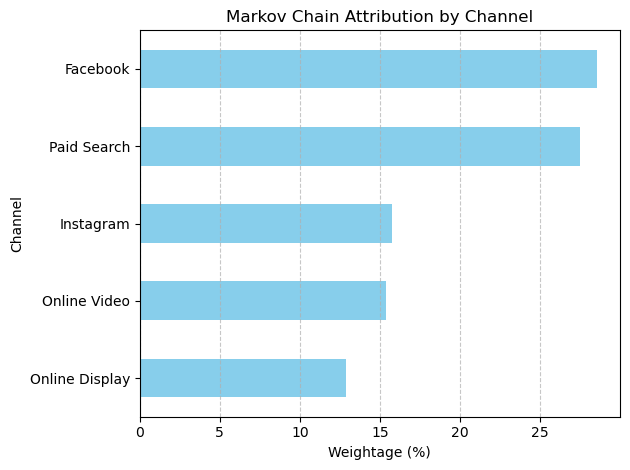

In [42]:
# Bar plot of Markov attribution
plt.figure(figsize=(10, 6))
markov.sort_values(by='Weightage(%)', ascending=True).plot(
    kind='barh',
    legend=False,
    color='skyblue'
)

plt.title('Markov Chain Attribution by Channel')
plt.xlabel('Weightage (%)')
plt.ylabel('Channel')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()